In [3]:
import os

In [25]:
ds_path = 'datasets'
folders = os.listdir(ds_path)

for sub in folders:
    listing = os.listdir(ds_path+'\\'+sub)
    print(sub+': '+str(len(listing)))
#     for vid in listing:
#         vid = ds_path+'\\'+sub+'\\'+vid
#         print(vid)


block: 45
dbjap: 45
hook: 47
jap: 45
none: 38
slip: 45
stance: 45
uppercut: 45


In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D

from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing

Using TensorFlow backend.
C:\Users\dpadmin\Anaconda3\envs\pycv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
import numpy as np
import os
import cv2

X_train = []  
# image specification
img_rows,img_cols,img_depth=224,224,30

ds_path = 'datasets'
# folders = os.listdir(ds_path)
folders = ['jap']#,'hook','uppercut','none']

for sub in folders:
    
    listing = os.listdir(ds_path+'\\'+sub)
    
    for vid in listing[:10]:
        vid = ds_path+'\\'+sub+'\\'+vid
        print(vid)
        frames = []
        cap = cv2.VideoCapture(vid)
        # cap = cv2.VideoCapture('datasets\\hook\\35.avi')
        fps = cap.get(cv2.CAP_PROP_FPS) 
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('number of frames = ' + str(frame_count))

        for k in range(int(frame_count)):
            ret, frame = cap.read()
            frame = cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            if k>10 and k<=44:
                frames.append(gray)

        #         plt.imshow(gray, cmap = plt.get_cmap('gray'))
        #         plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        #         plt.show()
        #         cv2.imshow('frame',gray)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        cap.release()
        cv2.destroyAllWindows()

        input=np.array(frames)
        ipt=np.rollaxis(np.rollaxis(input,2,0),2,0)
        X_train.append(ipt)

datasets\jap\1.avi
number of frames = 56
datasets\jap\10.avi
number of frames = 55
datasets\jap\11.avi
number of frames = 55
datasets\jap\12.avi
number of frames = 55
datasets\jap\13.avi
number of frames = 56
datasets\jap\14.avi
number of frames = 56
datasets\jap\15.avi
number of frames = 56
datasets\jap\16.avi
number of frames = 55
datasets\jap\17.avi
number of frames = 55
datasets\jap\18.avi
number of frames = 55


In [30]:
odd = [i for i in range(48) if i%2==1]
even = [i for i in range(48) if i%2==0]
print(len(odd))
print(len(even))

24
24


In [98]:
len(X_train)

175

In [86]:
X_train[1][:,:,1].shape

(224, 224)

In [75]:
X_train[1].shape

(224, 224, 30)

IndexError: index 34 is out of bounds for axis 2 with size 34

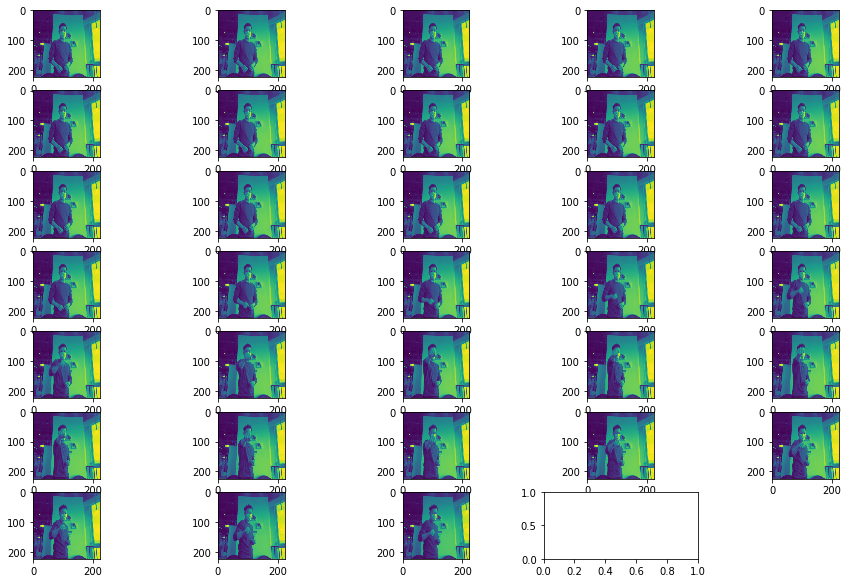

In [32]:
import matplotlib.pyplot as plt
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 11
for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[5][:,:,i])
plt.show()

In [101]:
X_train_array = np.array(X_train)   # convert the frames read into array

num_samples = len(X_train_array)
print(num_samples)

175


In [95]:
X_train_array[0].shape

(224, 224, 30)

In [102]:
np.save('xtrain_4', X_train_array)

In [21]:
label=np.ones((num_samples,),dtype = int)
label[0:6]= 0 # hook
label[6:13] = 1 # jap
label[13:20] = 2 # uppercut
# label[299:399] = 3
# label[399:499]= 4
# label[499:] = 5

In [23]:
train_data = [X_train_array,label]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

train_set = np.zeros((num_samples, 1, img_rows,img_cols,img_depth))

X_Train shape: (20, 128, 128, 25)


In [24]:
for h in range(num_samples):
    train_set[h][0][:][:][:]=X_train[h,:,:,:]


In [25]:
patch_size = 25    # img_depth or number of frames used for each video

print(train_set.shape, 'train samples')

(20, 1, 128, 128, 25) train samples


In [26]:
train_data[1]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

In [48]:
batch_size = 2
nb_classes = 3
nb_epoch =50

# number of convolutional filters to use at each layer
nb_filters = [  32,   # 1st conv layer
                32    # 2nd
             ]

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [3, 3]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [5,5]

# Pre-processing
train_set = train_set.astype('float32')
train_set -= np.mean(train_set)
train_set /= np.max(train_set)

In [52]:
Y_train = np_utils.to_categorical(y_train, nb_classes)

In [58]:
# Define model
model = Sequential()

model.add(Convolution3D(
        nb_filters[0],
        kernel_size=(nb_conv[0],nb_conv[0],nb_conv[0]),
        input_shape=(1, img_rows, img_cols, patch_size),
        activation='relu',
        data_format='channels_first'
    ))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(nb_classes))

model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', 
              # metrics=['mse', 'accuracy'])

sgd = SGD(lr=0.001)

model.compile( loss = "categorical_crossentropy", 
               optimizer = sgd, 
               metrics=['mse', 'accuracy'])

In [54]:
# Split the data
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(train_set, Y_train, test_size=0.2, random_state=4)

In [30]:
# Train the model
hist = model.fit(
    X_train_new,
    y_train_new,
    validation_data=(X_val_new,y_val_new),
    batch_size=batch_size,
    nb_epoch = nb_epoch,
    shuffle=True
    )

In [59]:
from keras.models import model_from_json
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)